<b>
    
<p>
<center>
<font size="5">
Exploratory Data Analysis
</font>
</center>
<center>
<font size="4">
EDA & Pre_Processing on the MovieLens Dataset
</font>
</center>
</p>
    
</b>

<p><h2>Table of Contents<span class="tocSkip"></span></h2></p>

<div class="toc"><ul class="toc-item">
    <li><span><a ><span>1&nbsp;&nbsp;</span>Overview</a></span></li>
    <li><span><a ><span>2&nbsp;&nbsp;</span>Import Library</a></span></li>
    <li><span><a ><span>3&nbsp;&nbsp;</span>Load Data</a></span></li>
    <li><span><a ><span>4&nbsp;&nbsp;</span>Visualization data</a></span></li>
    <li><span><a ><span>5&nbsp;&nbsp;</span>Pre_Processing data cho Content_Based</a></span></li>

### Overview

#### Aim
1. Trực quan hóa dữ liệu
2. Xử lí data làm đầu vào cho Content_Based(dùng các tag của người dùng cho các để tạo mô hình, tuy nhiên, số lượng bộ phim có tag vẫn chưa đủ nên thực hiện crawl thêm data từ trang https://www.imdb.com/title/imdbId/keywords)

### Import Library

In [2]:
import os
os.environ["SPARK_HOME"] = "/opt/spark"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/jre"

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from wordcloud import *

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession,SQLContext
spark = SparkSession.builder \
    .appName("Project") \
    .master("spark://127.0.0.1:7077") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "13g") \
    .config("spark.executor.cores", "8") \
    .config("spark.driver.extraJavaOptions", "-Xss512m") \
    .config("spark.executor.extraJavaOptions", "-Xss512m") \
    .getOrCreate()

23/05/27 14:10:15 WARN Utils: Your hostname, longcule-Inspiron-7591 resolves to a loopback address: 127.0.1.1; using 192.168.1.40 instead (on interface enx68e43b306c5a)
23/05/27 14:10:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/27 14:10:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/27 14:10:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Load Data

In [4]:
ratings_df = spark.read.csv("hdfs://127.0.0.1:9900/user/ratings.csv", header=True, inferSchema=True)
movies_df = spark.read.csv("hdfs://127.0.0.1:9900/user/movies.csv", header=True, inferSchema=True)
tags_df = spark.read.csv("hdfs://127.0.0.1:9900/user/tags.csv", header=True, inferSchema=True)

In [2]:
movies = pd.read_csv('movies.csv', header = 0)
ratings = pd.read_csv('/home/longcule/Downloads/ml-latest/ratings.csv', header = 0)
ratings.drop(columns='timestamp', axis=0, inplace=True)
# merge the two tables on movieId
data = pd.merge(movies, ratings, on='movieId')

### Visualization Data

In [5]:
# số lượng user đưa ra đánh giá 
num_users = ratings_df.select('userId').distinct().count()
print('No of Users who rated movies:', num_users)
# số lượng phim đã được đánh giá
num_movies = movies_df.select('movieId').distinct().count()
print('No of Movies:', num_movies)
# Tổng sô rating
num_ratings = ratings_df.select('rating').count()
print('No of ratings:', num_ratings)
# số lượng user đã gắn tag 
num_user_comments = tags_df.select('tag').distinct().count()
print('No of user comments:', num_user_comments)
# số lượng phim đã được gắn tag 
num_commented_movies = tags_df.select('movieId').distinct().count()
print('No of Movies commented by user:', num_commented_movies)

percent_commented_users = (num_user_comments / num_users) * 100
print('Percentage of user commented:', percent_commented_users, '%')

percent_commented_movies = (num_commented_movies / num_movies) * 100
print('No of movies commented by user:', percent_commented_movies, '%')

##### Trực quan hóa dữ liệu

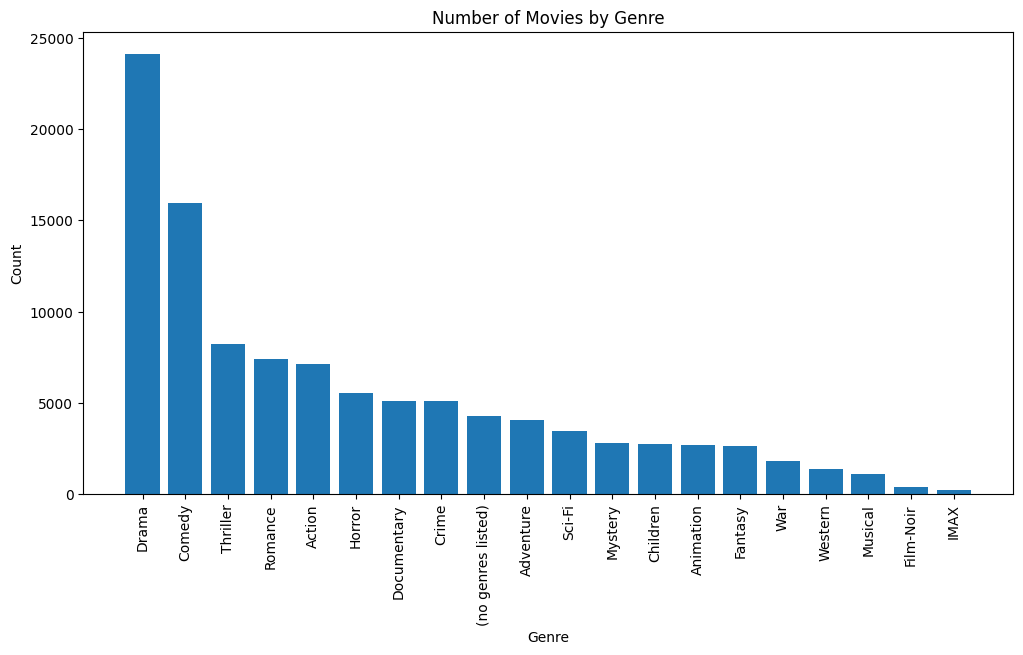

In [11]:
from pyspark.sql.functions import split, explode
import matplotlib.pyplot as plt
# Tách các thể loại 
movies_df = movies_df.withColumn('genre', explode(split(movies_df.genres, "\\|")))
genre_counts = movies_df.groupBy('genre').count().orderBy('count', ascending=False)
genre_counts_pandas = genre_counts.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(genre_counts_pandas['genre'], genre_counts_pandas['count'])
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of Movies by Genre')
plt.xticks(rotation=90)
plt.show()

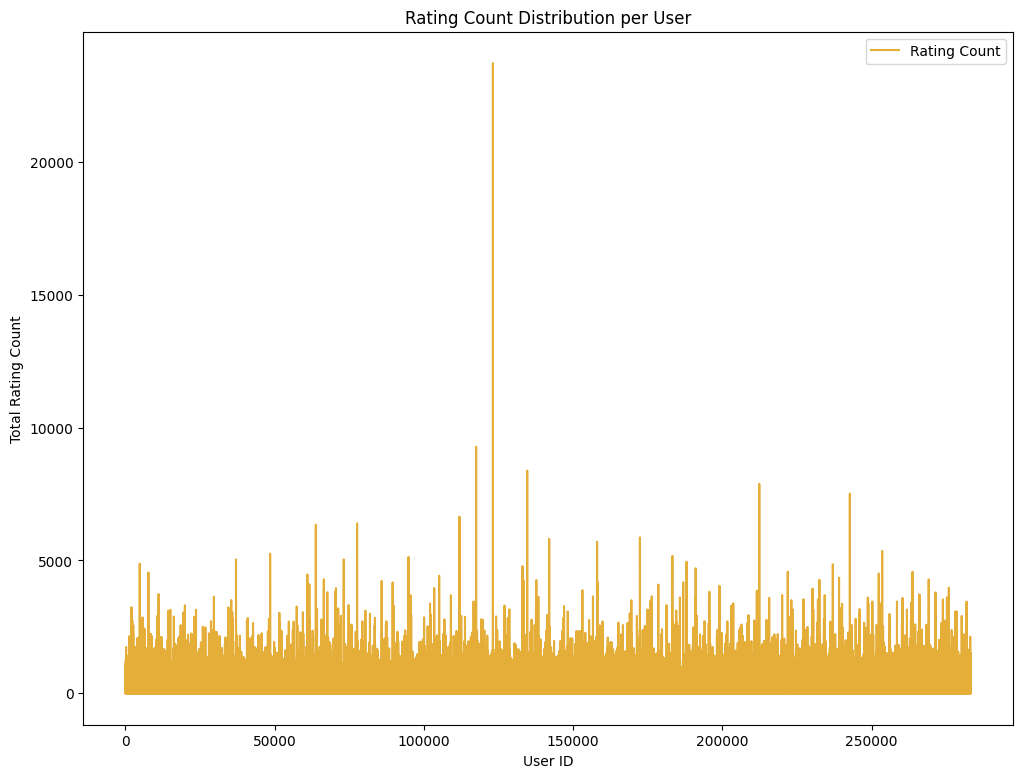

In [3]:
total_ratings_per_user = data.groupby('userId')['rating'].count()

total_ratings_per_user_df = total_ratings_per_user.reset_index()

userID = total_ratings_per_user_df['userId']
rating_count = total_ratings_per_user_df['rating']

plt.figure(figsize=(12, 9))
plt.plot(userID, rating_count, label='Rating Count', color='#e5ae38')
plt.xlabel('User ID')
plt.ylabel('Total Rating Count')
plt.title('Rating Count Distribution per User')
plt.legend()
plt.show()

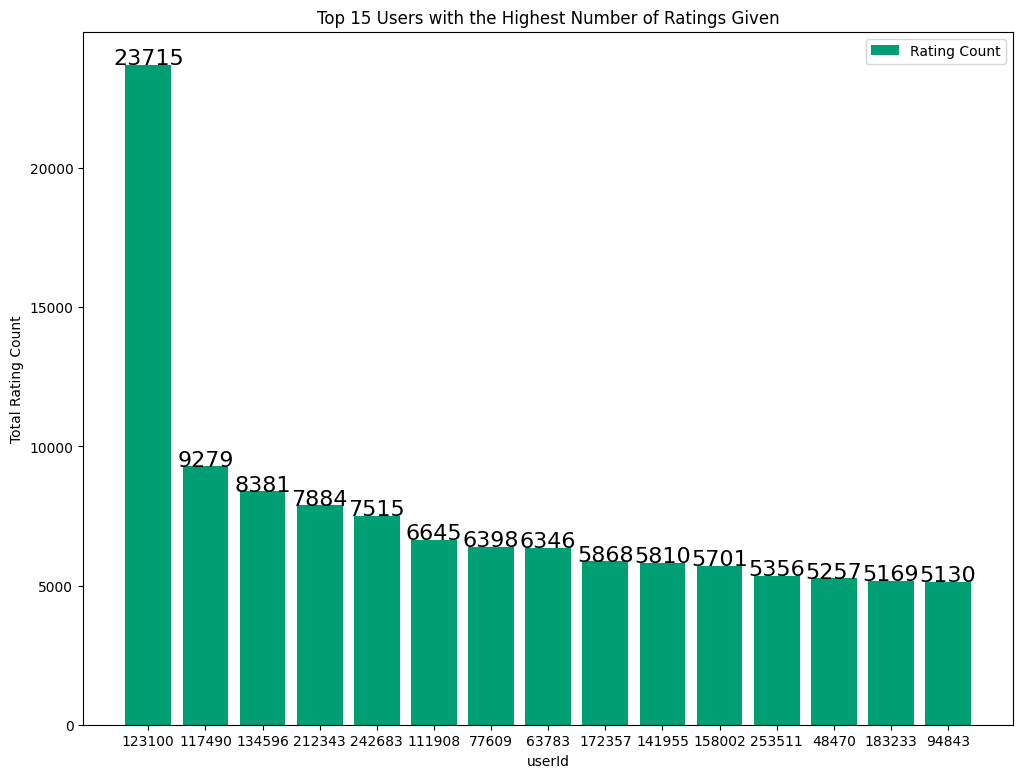

In [6]:
sorted_df = pd.DataFrame(total_ratings_per_user_df.sort_values(by='rating', ascending=False).reset_index(drop=True)[:15])
# sorted_df
userID_list = sorted_df['userId'].to_list()
ratings_list = sorted_df['rating'].to_list()
# plot for x-axis as userId, y-axis as total rating count
x_pos = np.arange(len(userID_list))
# x_pos
plt.figure(figsize=(12,9))
plt.xticks(x_pos, userID_list)
plt.bar(x_pos, ratings_list, label = 'Rating Count', color = '#009E73')
# pale yellow:#feffb3 dark yello: #ffed6f nice blue: #348ABD pale green: #8dd3c7
plt.xlabel('userId')
plt.ylabel('Total Rating Count')
plt.title('Top 15 Users with the Highest Number of Ratings Given')
plt.legend()
# create a for loop to enumerate the bar plot with the rating count of the displayed users
for i, val in enumerate(ratings_list):
    plt.text(i, val+10, s=val, fontsize=16, horizontalalignment= 'center')
plt.show()

In [9]:
genre = movies['genres']

In [10]:
# Collect the unique set of all the genres
def list_of_genres(df):
    genre_list = []
    for i in range(len(df)):
        each_genre = df.iloc[i]
        # split the string (movie title) and add to a list 
        string_split = each_genre.split("|")
        #     print(string_split)
        for each in string_split:
            if each not in genre_list:
                genre_list.append(each)
    return genre_list

print('This dataset include movies from the following list of genres:')
genre_list = list_of_genres(genre)
for i, val in enumerate(genre_list):
    print(i,'.', val)

This dataset include movies from the following list of genres:
0 . Adventure
1 . Animation
2 . Children
3 . Comedy
4 . Fantasy
5 . Romance
6 . Drama
7 . Action
8 . Crime
9 . Thriller
10 . Horror
11 . Mystery
12 . Sci-Fi
13 . IMAX
14 . Documentary
15 . War
16 . Musical
17 . Western
18 . Film-Noir
19 . (no genres listed)


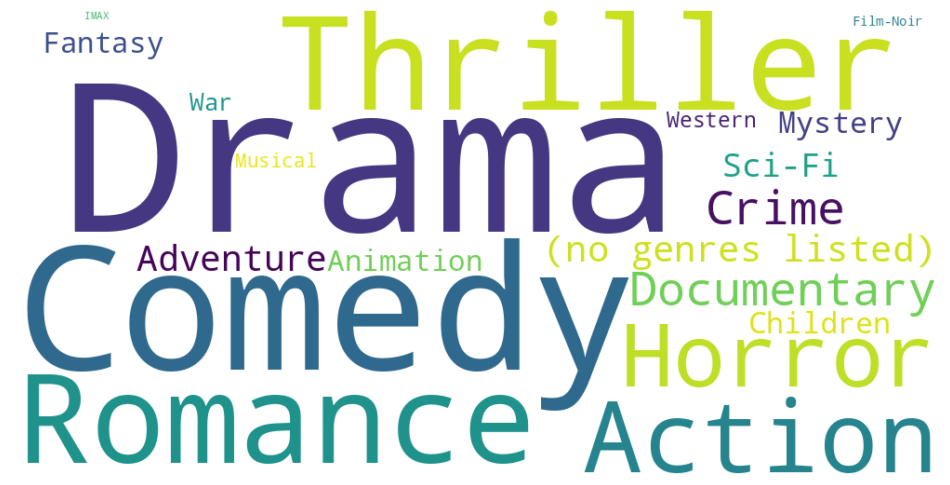

In [11]:
def wordcloud_genres(genre_data):
    # create a list of the genres
    genre_census = list()
    for each in genre_data:
      # print(each)
      string_split = each.split('|')
      # print(string_split)
      for i in string_split:
        genre_census.append(i)
    # create a dictionary where key=genre, value=movie count    
    movie_count_by_genre = dict()
    # use for loop to add genres as key
    for i in genre_census:
        movie_count_by_genre[i] = 0
        
  # using for loop count the number of movies in each genre (with repetition) as values
    for i in genre_census:
        if i in genre_census:
            movie_count_by_genre[i] += 1
  # sort the dictionary based on highest movie count
    total_movie_count = []
    for key,val in movie_count_by_genre.items():
        total_movie_count.append([key,val])
        total_movie_count.sort(key = lambda x:x[1], reverse = True)
  # display the genres by highest movie count
    total_movie_count_list = total_movie_count
    total_movie_count_dict = {}
    for i in total_movie_count_list:
        total_movie_count_dict[i[0]] = i[1]
    # print(total_movie_count_dict)
  
  # create the wordcloud by movie frequency
    genre_wordcloud = WordCloud(width=1000,height=500, background_color='white')
    genre_wordcloud.generate_from_frequencies(total_movie_count_dict)

    plt.figure(figsize=(12, 9))
    plt.imshow(genre_wordcloud, interpolation="bilinear")
    plt.axis('off')
    return plt.show() 

wordcloud_genres(genre)

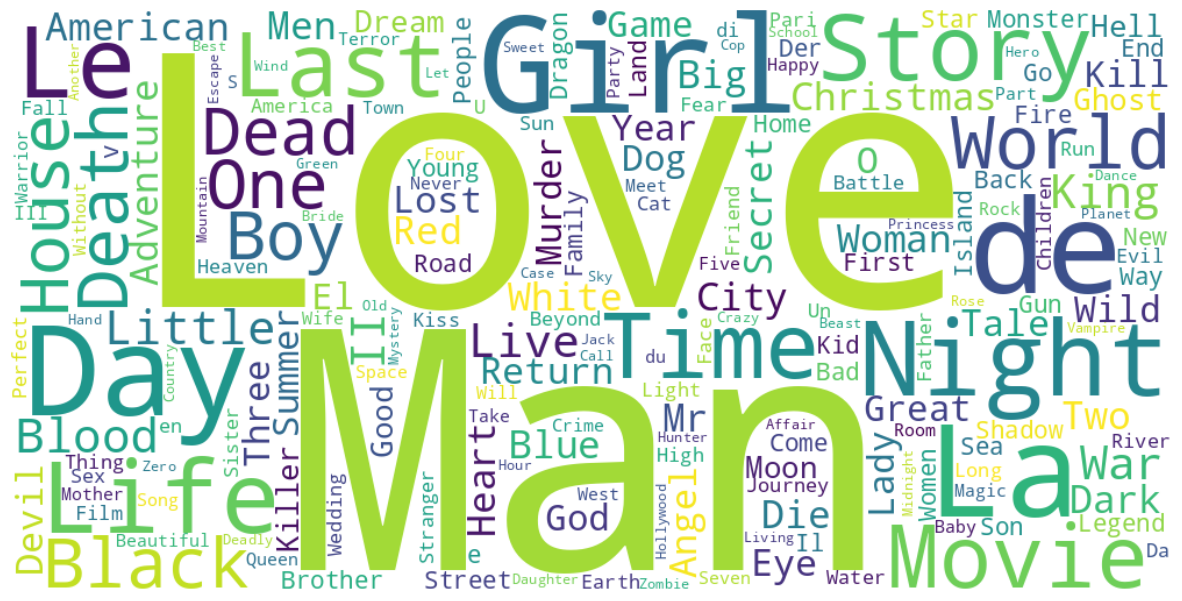

In [12]:
# create a series of movie titles and convert each row to string
movie_titles = movies['title'].astype('str')
# movie_titles
# store all the movie titles 
title_corpus = ''.join(movie_titles)
# print(title_corpus)
# eliminate stopwords and create wordcloud
title_wordcloud = WordCloud(stopwords=STOPWORDS, width=1000, height=500, background_color='white').generate(title_corpus)
plt.figure(figsize=(15, 10))
plt.imshow(title_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [13]:
movie_copy = movies.copy(deep=True)
# count the total number of ratings given to each movie
average_movie_rating_count = pd.DataFrame(data.groupby('movieId')['rating'].count())
average_movie_rating_count = average_movie_rating_count.reset_index()
movie_copy = pd.merge(movie_copy, average_movie_rating_count, on='movieId')
# find the average rating given to each movie
average_rating = pd.DataFrame(data.groupby('movieId')['rating'].mean())
average_rating = average_rating.reset_index()
# merge the previous 2 dataframes, to create final dataframe
movie_copy = pd.merge(movie_copy, average_rating, on='movieId')
movie_copy = movie_copy.rename(columns={'rating_x':'rating count', 'rating_y': 'average rating'})
# sort values by highest rating count
movie_copy = movie_copy.sort_values(by='rating count', ascending=False).reset_index(drop=True)
# sort the new dataframe by the highest average count
top_movies_df = movie_copy.sort_values(by='average rating', ascending=False).reset_index(drop=True)
top_movies_df = top_movies_df.sort_values(by='rating count', ascending=False).reset_index(drop=True)
top_movies_df_20 = top_movies_df[:20]
top_movies_df_20 = top_movies_df_20.sort_values(by='average rating', ascending=False).reset_index(drop=True)
# display top 20 movies
top_movies_df_20

,movieId,title,genres,rating count,average rating
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,97999,4.424188
1,858,"Godfather, The (1972)",Crime|Drama,60904,4.332893
2,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,62180,4.291959
3,527,Schindler's List (1993),Drama|War,71516,4.257502
4,2959,Fight Club (1999),Action|Crime|Drama|Thriller,65678,4.230663
5,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,92406,4.173971
6,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,87899,4.151412
7,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,84545,4.149695
8,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,65822,4.133481
9,2858,American Beauty (1999),Drama|Romance,60820,4.121506


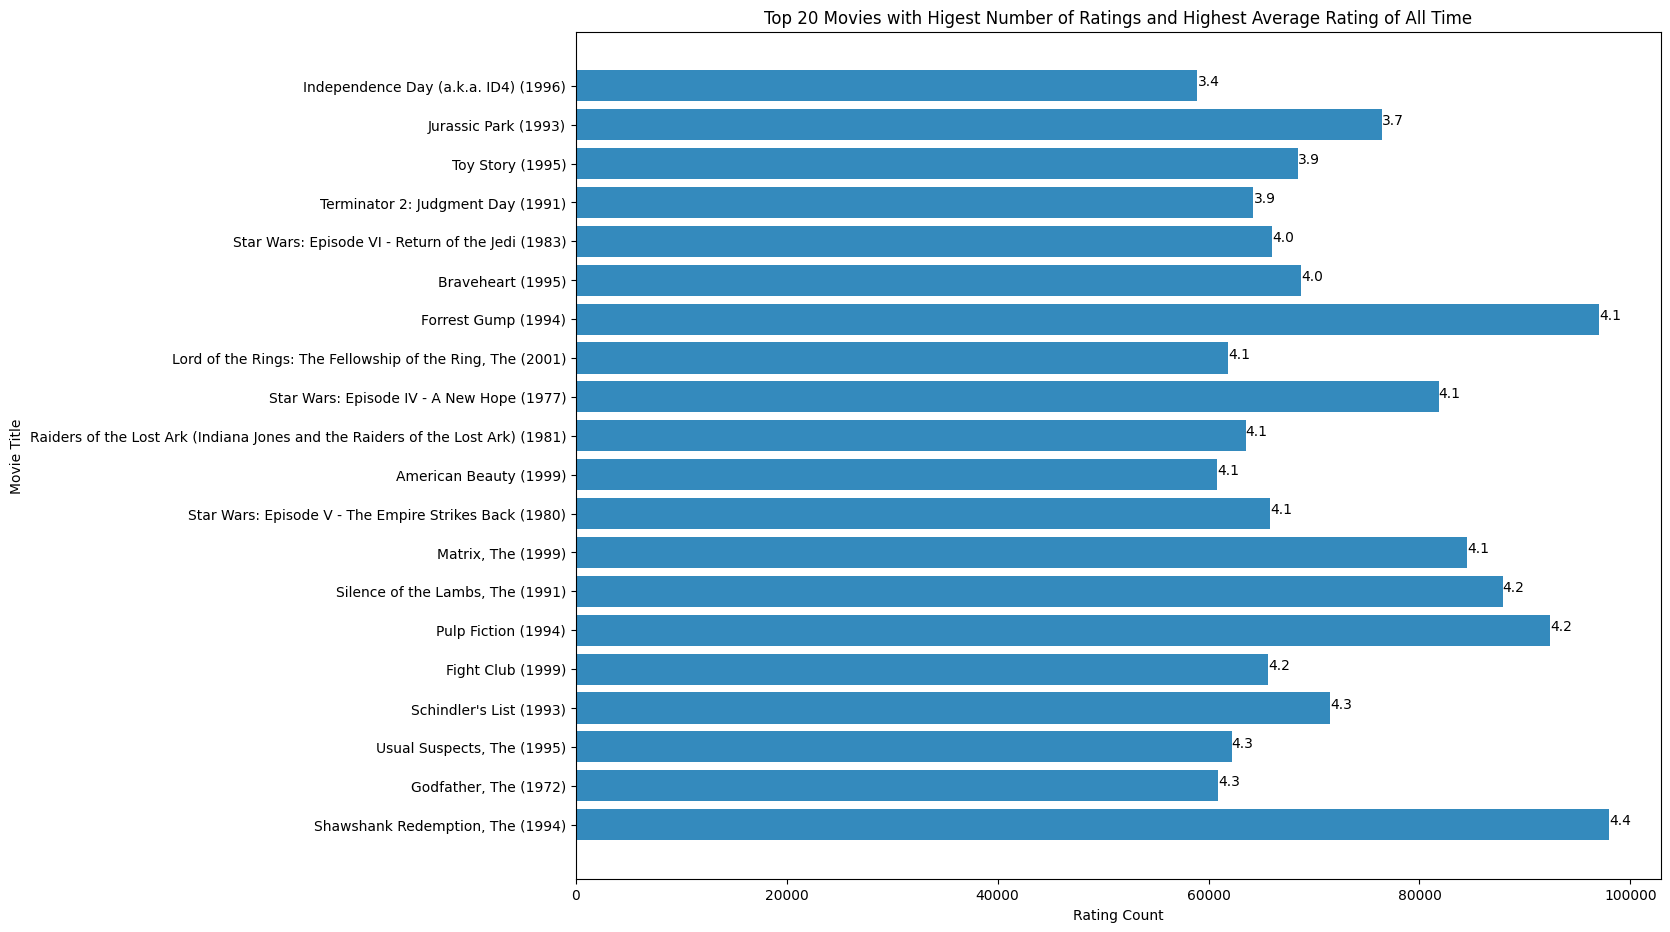

In [14]:
# create a plot to display the top 20 movies of all time
rating_count_list = top_movies_df_20['rating count'].to_list()
average_rating_list = top_movies_df_20['average rating'].to_list()
movie_title_list = top_movies_df_20['title'].to_list()
new_average_rating_list = []
for i in average_rating_list:
  new_average_rating_list.append("{:.1f}".format(i))
y_pos = np.arange(len(movie_title_list))
# y_pos
plt.figure(figsize=(14,11))
plt.yticks(y_pos, movie_title_list)
plt.barh(y_pos, rating_count_list, color='#348ABD') # pale yellow:#feffb3 dark yello: #ffed6f nice blue: #348ABD pale green: #8dd3c7
plt.xlabel('Rating Count')
plt.ylabel('Movie Title')
plt.title('Top 20 Movies with Higest Number of Ratings and Highest Average Rating of All Time')
# use for loop to enumerate the average ratings for each movie
for i, val in enumerate(new_average_rating_list):
    plt.text(rating_count_list[i]+3, i, s=val)
plt.show()

In [15]:
def top_20_movies_by_genre(selected_genre):
    genre_subset = []
    for each in movies['genres']:
        genre_subset.append(each)
    genre_subset = pd.DataFrame(genre_subset,columns=['genre subset'])
    movie_copy = movies.copy(deep=True)
    movie_copy['genre subset'] = genre_subset
    movie_copy = movie_copy.drop(columns='genres')
    average_movie_rating_count = pd.DataFrame(data.groupby('movieId')['rating'].count())
    average_movie_rating_count = average_movie_rating_count.reset_index()
    movie_copy = pd.merge(movie_copy, average_movie_rating_count, on='movieId')
    average_rating = pd.DataFrame(data.groupby('movieId')['rating'].mean())
    average_rating = average_rating.reset_index()
    movie_copy = pd.merge(movie_copy, average_rating, on='movieId')

    genre_sub = dict()
    for i in movie_copy['movieId']:
        genre_sub[i] = movie_copy[movie_copy['movieId']==i]['genre subset']

    for key, val in genre_sub.items():
        for each in val:
            genre_sub[key] = each
  
    id_list = []
    for k, v in genre_sub.items():
        if selected_genre in v:
            id_list.append(k)

    id_list_df = pd.DataFrame(id_list, columns=['movieId'])
    top_genre_movie_list = pd.merge(movie_copy, id_list_df, on='movieId')
    top_genre_movie_list = top_genre_movie_list.sort_values(by='rating_x', ascending=False).reset_index(drop=True)
    top_genre_movie_list_20 = top_genre_movie_list[:20]
    top_genre_movie_list_20 = top_genre_movie_list_20.sort_values(by='rating_y', ascending=False).reset_index(drop=True)
    # top_genre_movie_list_20 = top_genre_movie_list_20.drop(columns=['level_0', 'index'])
    top_genre_movie_list_20 = top_genre_movie_list_20.rename(columns={'genre subset':'genre', 'rating_x':'total ratings', 'rating_y':'average rating'})
    print('The Top 20 Movies in the', selected_genre, 'are:')
    print('(Based on Highest Number of Ratings and Highest Average Rating)')
    return top_genre_movie_list_20

In [16]:
top_20_movies_by_genre('Musical')

The Top 20 Movies in the Musical are:
(Based on Highest Number of Ratings and Highest Average Rating)


,movieId,title,genre,total ratings,average rating
0,919,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical,27436,3.944708
1,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,47305,3.811426
2,1035,"Sound of Music, The (1965)",Musical|Romance,17154,3.800950
3,1220,"Blues Brothers, The (1980)",Action|Comedy|Musical,23154,3.794355
4,551,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical,24134,3.736679
5,1028,Mary Poppins (1964),Children|Comedy|Fantasy|Musical,17011,3.715508
6,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical,33411,3.701880
7,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,51827,3.691753
8,1282,Fantasia (1940),Animation|Children|Fantasy|Musical,14715,3.686137
9,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,42400,3.679634


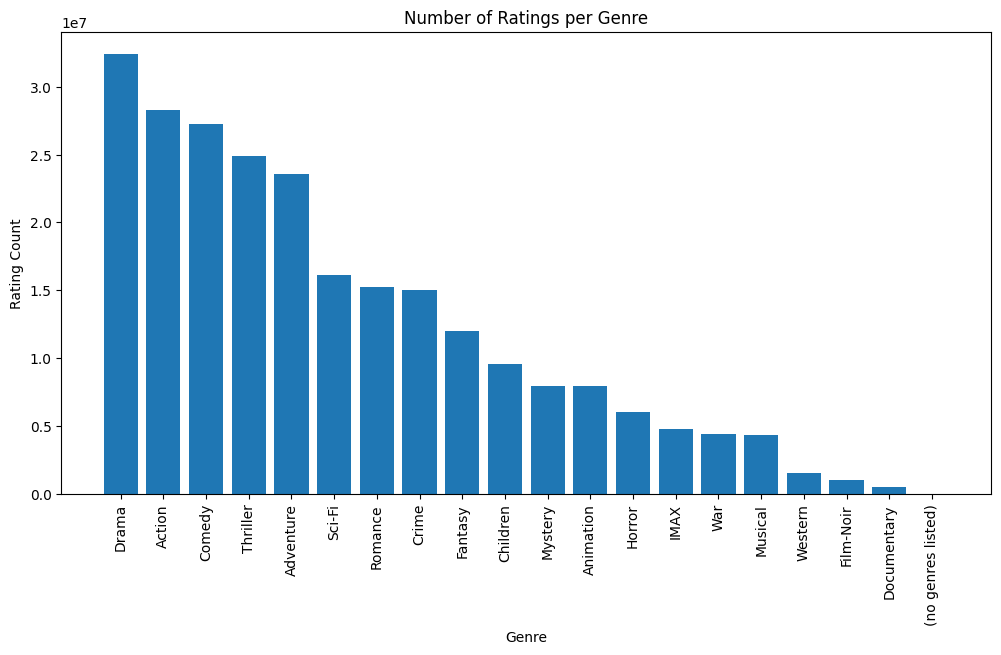

In [19]:
from pyspark.sql.functions import count
exploded_df = movies_df.select("movieId", "title", explode(split(movies_df.genres, "\\|")).alias("genre"))
joined_df = exploded_df.join(ratings_df, on="movieId")
genre_ratings_counts = joined_df.groupBy("genre").agg(count("rating").alias("rating_count")).orderBy("rating_count", ascending=False)
genre_ratings_counts_pandas = genre_ratings_counts.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(genre_ratings_counts_pandas["genre"], genre_ratings_counts_pandas["rating_count"])
plt.xlabel("Genre")
plt.ylabel("Rating Count")
plt.title("Number of Ratings per Genre")
plt.xticks(rotation=90)
plt.show()

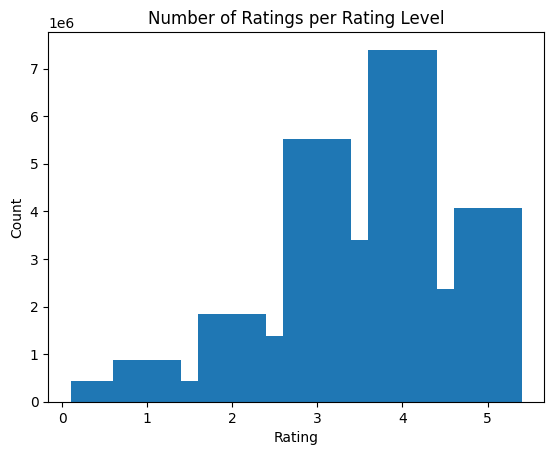

In [20]:
rating_counts = ratings_df.groupBy('rating').agg(count('rating').alias('rating_count')).orderBy('rating')
rating_counts_pandas = rating_counts.toPandas()

plt.bar(rating_counts_pandas['rating'], rating_counts_pandas['rating_count'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Number of Ratings per Rating Level')
plt.show()

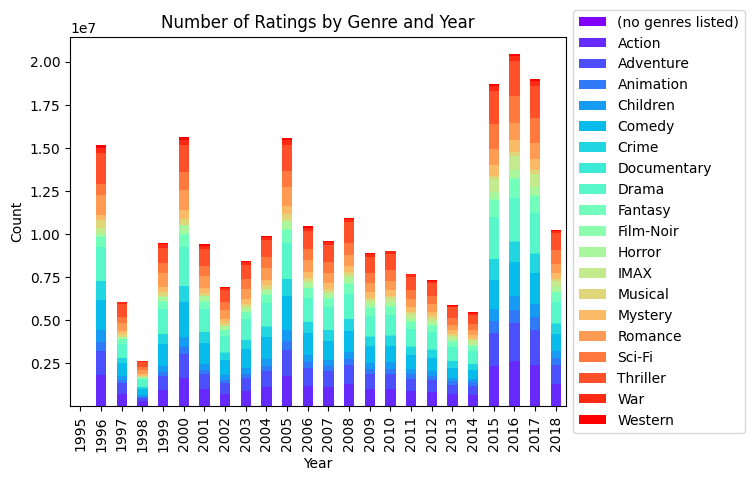

In [36]:
from pyspark.sql.functions import explode, year, col
import matplotlib.pyplot as plt
import pandas as pd

merged_df = ratings_df.join(movies_df, on='movieId')
exploded_df = merged_df.withColumn('genre', explode(split('genres', '[|]')))
exploded_df = exploded_df.withColumn('timestamp', col('timestamp').cast('timestamp'))
exploded_df = exploded_df.withColumn('Year', year('timestamp'))

genre_year_rating_counts = exploded_df.groupby('genre', 'Year').count()
df_pandas = genre_year_rating_counts.toPandas()
df_pivot = df_pandas.pivot(index='Year', columns='genre', values='count')

ax = df_pivot.plot.bar(stacked=True, colormap='rainbow')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Ratings by Genre and Year')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


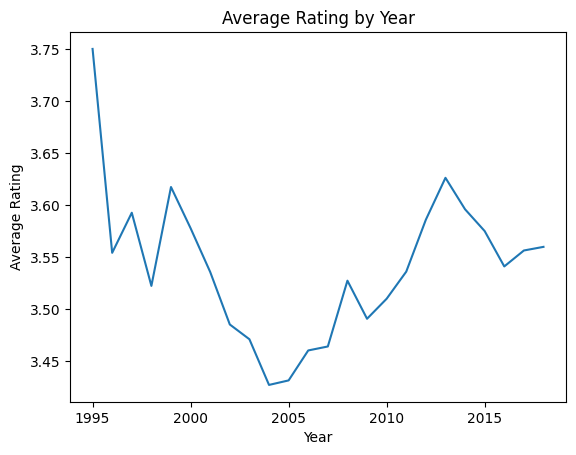

In [39]:
from pyspark.sql.functions import year, avg
import matplotlib.pyplot as plt
# Chuyển đổi trường "timestamp" sang kiểu dữ liệu chuỗi thời gian (string)
ratings_df = ratings_df.withColumn('timestamp', ratings_df['timestamp'].cast('timestamp').cast('string'))
ratings_df = ratings_df.withColumn('Year', year('timestamp'))
# Tính trung bình rating qua mỗi năm
average_rating_by_year = ratings_df.groupby('Year').agg(avg('rating').alias('average_rating')).orderBy('Year')
df_pandas = average_rating_by_year.toPandas()

plt.plot(df_pandas['Year'], df_pandas['average_rating'])
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating by Year')
plt.show()



### Xử lí dữ liệu đầu vào của Conttent_Based 

In [5]:
tag_df = spark.read.csv('hdfs://127.0.0.1:9900/user/tags.csv', header=True,inferSchema="true")
tag_df.show()
display(tag_df)

+------+-------+--------------+----------+
|userId|movieId|           tag| timestamp|
+------+-------+--------------+----------+
|    14|    110|          epic|1443148538|
|    14|    110|      Medieval|1443148532|
|    14|    260|        sci-fi|1442169410|
|    14|    260|  space action|1442169421|
|    14|    318|  imdb top 250|1442615195|
|    14|    318|       justice|1442615192|
|    14|    480|     Dinosaurs|1443148563|
|    14|    593|psychothriller|1444014286|
|    14|   1682|    philosophy|1442615158|
|    14|   1682|  surveillance|1442615167|
|    14|   7458|          Epic|1443148675|
|    14|  95311|         Pixar|1443148494|
|    14| 117529|     dinosaurs|1443148646|
|    27|    260|classic sci-fi|1440448113|
|    27|    260| Harrison Ford|1440448123|
|    27|    260|      must see|1440448132|
|    27|    260|        sci-fi|1440448094|
|    42|  37733| disappointing|1264106059|
|    42|  37733|     overrated|1264106052|
|    42|  37733|        stupid|1264106067|
+------+---

DataFrame[userId: int, movieId: int, tag: string, timestamp: string]

In [7]:
from pyspark.sql.functions import col
distinct_movie_count = tag_df.select(col("movieId")).distinct().count()

# In kết quả
print("Số lượng movieId riêng biệt trong DataFrame là:", distinct_movie_count)

Số lượng movieId riêng biệt trong DataFrame là: 45981


- Có thể thấy số lượng phim trong tags.csv là hơn 45000 phim trong phi đó tệp movié.csv có hơn 58000 phim, nên cần phải crawl thêm data 
- Từ file tags.csv, trích xuất ra các bộ phim đã có tag và đối chiếu với file movies.csv, sau đó sẽ tìm được ra những phim không có tag, từ những phim đó, kết hợp với imdbId trong file links.csv để tạo được list các bộ phim và imdbId của bộ phim đó.

Sau khi có file imdbId.csv, tiến hành crawl data từ trang https://www.imdb.com/title/imdbId/keywords dạng:
url = "https://www.imdb.com/title/tt" + imdb_id + "/keywords"
- Vì khi crawl sẽ gây ra lỗi không request được đến URL nên đặt biến "max_retries" để khi không request được đến đường link thì sẽ request lại, nếu quá 30 lần mà không được thì bỏ qua.

=> Cuối cùng, sẽ tạo được file tags2.csv với 2 cột là imdbId và tag, sau đó chuyển cột imdbId sang movieId và merge với file tags.csv ban đầu

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup

imdb_ids = []

# mở file csv chứa danh sách imdbId
with open('imdbId.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # bỏ qua header row

    for row in csv_reader:
        imdb_id = row[0]

        # Số lần tìm kiếm tối đa cho mỗi imdb_id
        max_retries = 30
        retry_count = 0

        while retry_count < max_retries:
            url = "https://www.imdb.com/title/tt" + imdb_id + "/keywords"

            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
            }

            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                soup = BeautifulSoup(response.content, "html.parser")

                ul_tag = soup.find("ul", class_="ipc-metadata-list")

                if ul_tag is not None:
                    li_elements = ul_tag.find_all("li")
                    li_text_content = [li.get_text(strip=True) for li in li_elements]

                    # mở file csv để ghi
                    with open('tags2.csv', mode='a', newline='') as csv_file:
                        writer = csv.writer(csv_file)

                        for text_content in li_text_content:
                            writer.writerow([imdb_id, text_content])

                    break
                else:
                    print(f"The ul element was not found for imdbId {imdb_id}. Retrying...")
                    retry_count += 1
            else:
                print(f"Failed to access the website for imdbId {imdb_id}. Retrying...")
                retry_count += 1